# Modeling Continuous Targets: Building and Interpreting Bayesian Regressions

<br>

***

<br>

## Import Libraries

In [7]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.datasets import fetch_california_housing

print(f"PYMC Version {pm.__version__}")

PYMC Version 5.15.0


<br>

***

<br>

## Import Data

In [ ]:
# MedInc median income in block group

# HouseAge median house age in block group

# AveRooms average number of rooms per household

# AveBedrms average number of bedrooms per household

# Population block group population

# AveOccup average number of household members

# Latitude block group latitude

# Longitude block group longitude

df = fetch_california_housing(as_frame=True)
df = df.frame
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

This dataset has 20640 rows and 9 columns


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<br>

***

<br>

## Explore Data

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


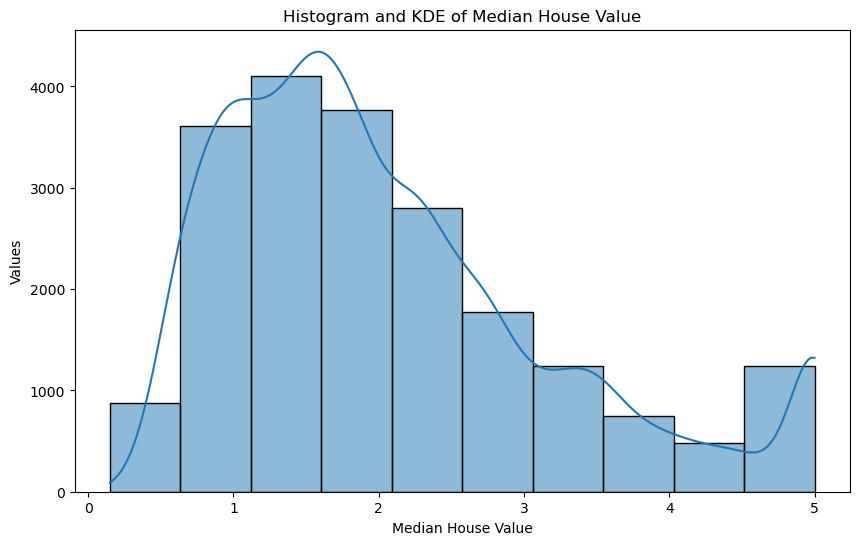

In [ ]:
# Null values for features?
print(df.isna().sum())

# What are the data types?
print(df.info())

# Histogram & KDE plot of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseVal'], kde=True, bins=10)
plt.title('Histogram and KDE of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Values')
plt.show()

<br>

***

<br>

## Standardize Features

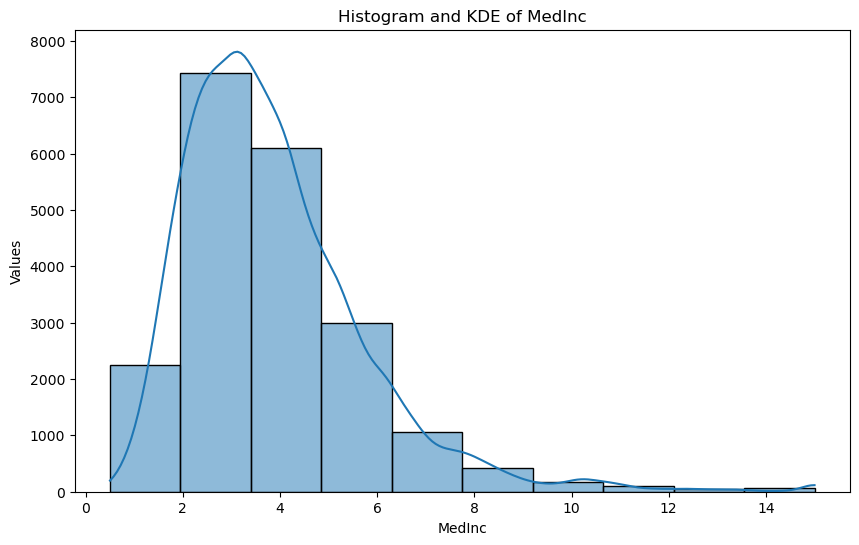

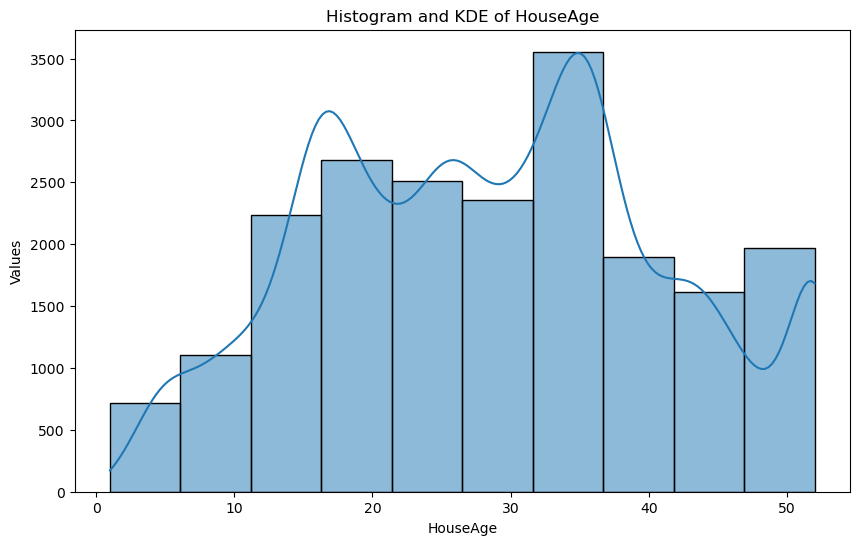

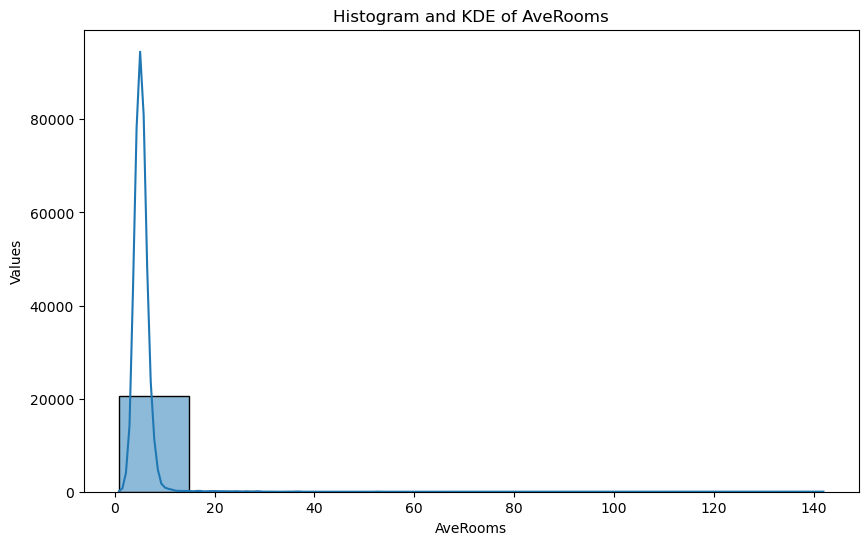

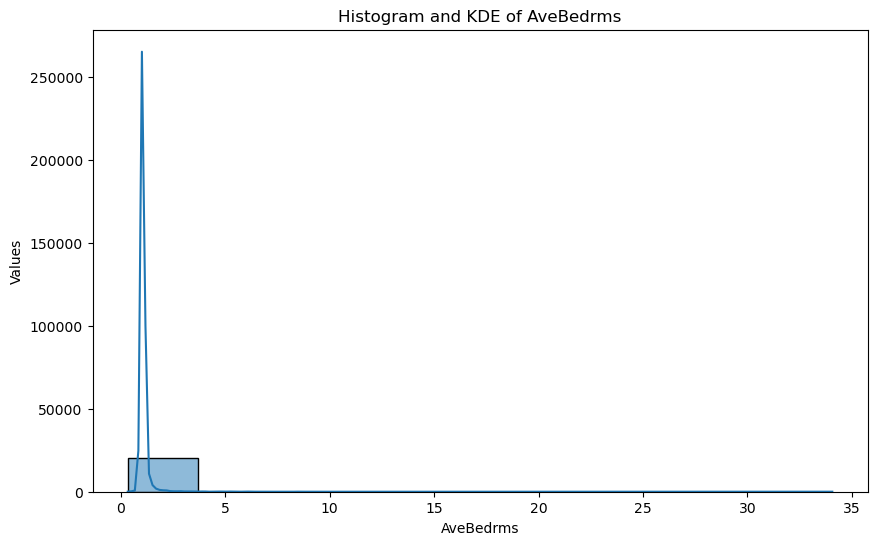

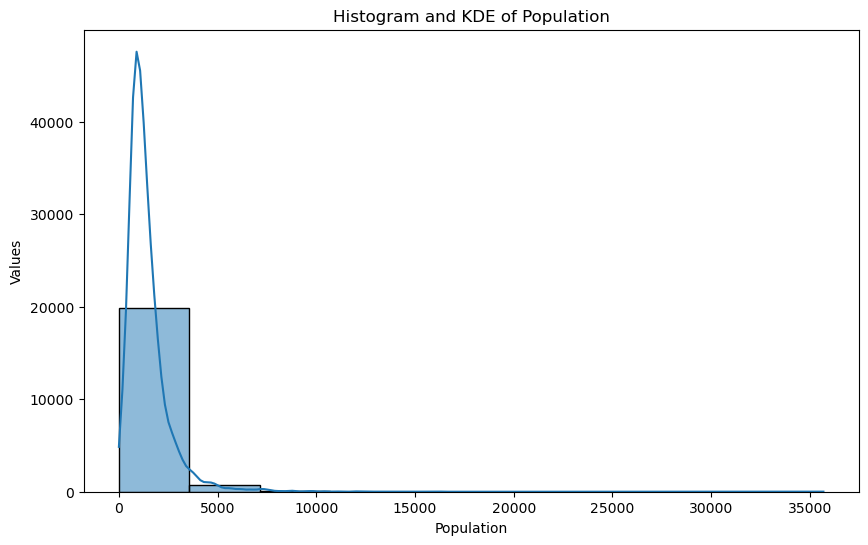

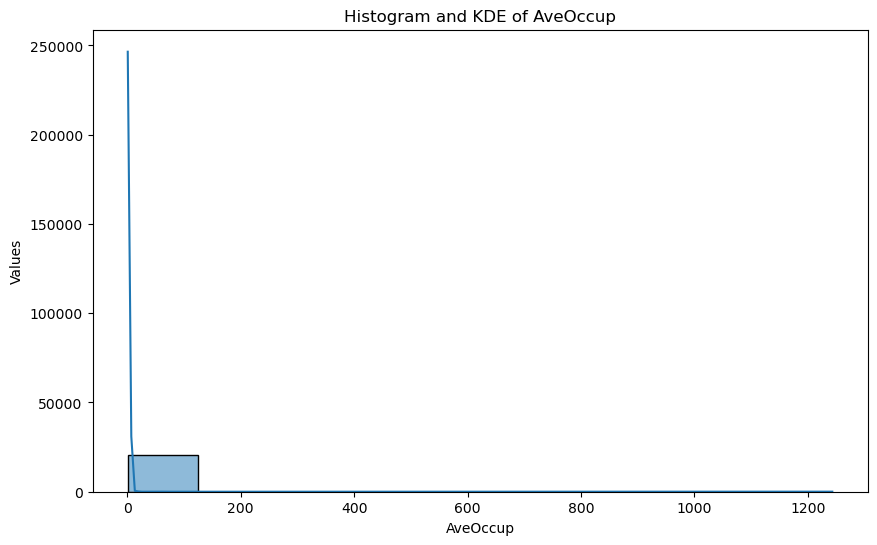

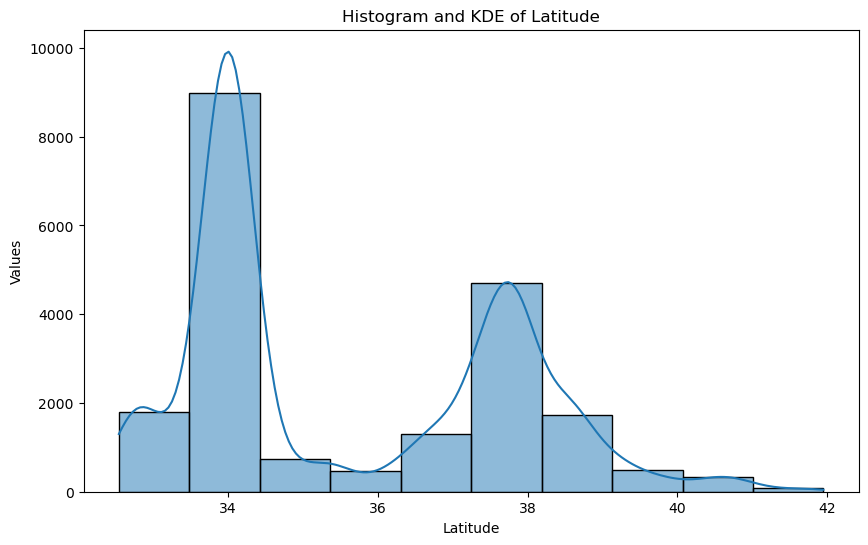

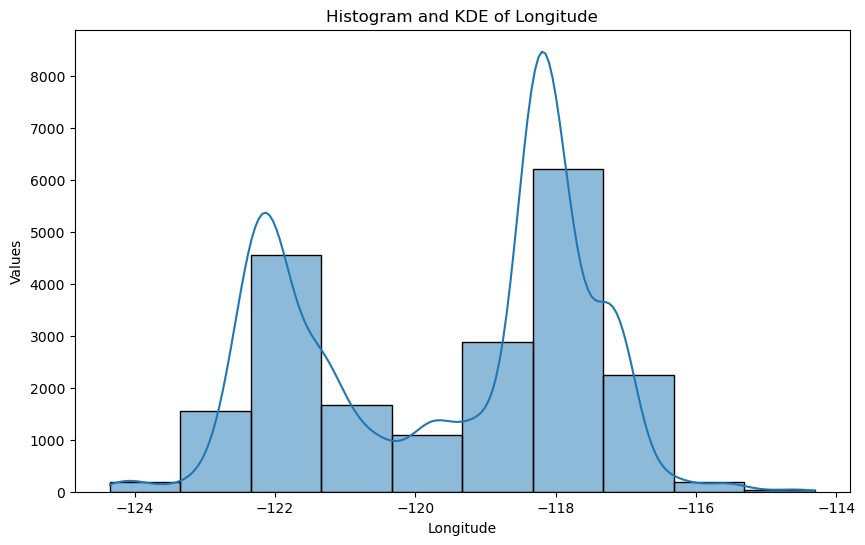

In [10]:
# Standardize features to have a mean of 0 and a standard deviation of 1
# Why? sampling efficiency (NUTS), numerical stability (MCMC), you can transform back to normal at the end (or not - interpret the standard deviation)
# Seen it split the runtime in half for some models, but not always the case
# x_norm = (x - x.mean()) / x.std()

# Find Features
X = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
y = df['MedHouseVal']

# Histogram & KDE plot of the features
for col in X.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(X[col], kde=True, bins=10)
    plt.title(f'Histogram and KDE of {col}')
    plt.xlabel(col)
    plt.ylabel('Values')
    plt.show()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = (y - y.mean()) / y.std()

# Convert scaled features to tensors
X_shared = pm.floatX(X_scaled)
y_shared = pm.floatX(y_scaled)

<br>

***

<br>

## Design & Train PYMC Model

In [ ]:
with pm.Model() as bayesian_model:
# Use the Model function in PYMC to create & name your model, then change parameters within the context of the model
    
    # Step 1: Priors
    # mu -> the center or mean of your data - if you think your coef is + then set the mu to a positive value, same for negative
    # sigma -> the standard deviation or spread of your data - a small sd would indicate strong confidence in your prior, whereas a large sd indicates uncertainty
    # examples -> mu=2 sigma=1 indicate strong priors; mu=1 sigma=10 indicate weak priors; mu=0 sigma=100 indicate uninformative priors
        # Use priors to input domain knowledge, regularlization to avoid overfitting, and make small data more robust
    
    # intercept -> represents the predicted value of the dependent variable when all independent variables are equal to zero
    # features (betas) -> even if you have features that are binary, set the prior distributions to normal distributions
        # This is because it's the variable that is binary, not the coefficient
    # mu is 0 because we do not have a prior about the intercept
    # sigma is 1 because we have some uncertainty about the prior
    # the first variable is the python name which can be used to reference the variable
    # the second variable in quotes is PYMC variable name which is a label you'll see in your plots

    # Priors for intercept
    intercept = pm.Normal('Intercept', mu=0, sigma=1)

    # Priors for each feature based on domain knowledge
    beta_medinc = pm.Normal("MedianIncome", mu=1, sigma=0.5)     # Expecting a positive influence
    beta_houseage = pm.Normal("HouseAge", mu=0.5, sigma=0.5)  # Moderate positive effect
    beta_averagerooms = pm.Normal("AvgRooms", mu=1, sigma=0.5)  # Positive effect
    beta_aveoccup = pm.Normal("AvgOccupancy", mu=0, sigma=1)    # Neutral or negative effect
    beta_latitude = pm.Normal("Latitude", mu=0, sigma=1)    # Weak prior, location-specific
    beta_longitude = pm.Normal("Longitude", mu=0, sigma=1)  # Weak prior, location-specific

    # Another way of writing this if you have a lot of features
        # beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1] - 1)
        # logits = intercept + pm.math.dot(X.iloc[:, 1:], beta)
    # or this...
        # import pytensor.tensor as at
        # features = pm.Model(coords={"predictors": columns}) # outside of the pm.Model() context
        # beta = pm.Normal("beta", 0, 10, dims="predictors")
        # beta0 = pm.Normal("beta0", 0, 10)
        # mu = beta0 + at.dot(X, beta)

    # ==================================================== #
    # Logistic Likelihood                                  #
    # ==================================================== #

    # Step 2: Likelihood
        # The likelihood is the probability of observing the data given the parameters
        # Multiply the prior by the actual data to get the likelihood

    # Regression Formula
    mu = (intercept 
          + beta_medinc * X_shared[:, 0] 
          + beta_houseage * X_shared[:, 1] 
          + beta_averagerooms * X_shared[:, 2] 
          + beta_aveoccup * X_shared[:, 3] 
          + beta_latitude * X_shared[:, 4] 
          + beta_longitude * X_shared[:, 5])
    
    # Likelihood (sampling distribution) of observations
        # Normal distribution for continuous target
        # Using a half normal sigma to ensure the standard deviation is positive
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_shared)

    # ==================================================== #
    # MCMC NUTS Process                                    #
    # ==================================================== #
    
    # Step 3: Inference

    # Push the Magic Inference Button for sampling
    # 2000 samples -> from the posterior distribution (2000-5000 is good, closer to 100000 is better)
        # More is better, the samples build up over time as it explores the space - only downside is time and resources
        # Increase when you have a complex model or want precision
        # Decrease when you want to save time or are prototyping
    # 4 Chains -> Ensure convergence & increase sampling diversity, improves stability
        # 1. Diagnostics for convergence -> they should overlap in the trace plots
        # 2. Avoiding local minima -> The chains are exploring a posterior space and can get caught in local regions of space
        # 3. Poor mixing happens when MCMC struggles to move across parameter space, multiple chains helps here
        # 4. Improves effectiveness of small sample sizes, improves autocorrelation and improves quality of inferences
        # Use for complex models, diagnositcs, uncertain priors, multi-modal posteriors
    # 1000 Tuning Steps -> These will tune the sampler before your actual samples are taken
    # 0.9 Target Acceptance Rate -> Recommended 0.8 to 0.95, higher is more accurate and stable, but slower

    # Inference Object
    trace = pm.sample(2000, chains=4, tune=1000, target_accept=0.9)

    # After sampling, you can convert the coefficients back to the original scale for interpretation
        # beta_var1_original = trace['beta_var1'].mean() * x['var1'].std()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, MedianIncome, HouseAge, AvgRooms, AvgOccupation, Latitude, Longitude, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 88 seconds.


<br>

***

<br>

## Visualize Model Results & Diagnostics

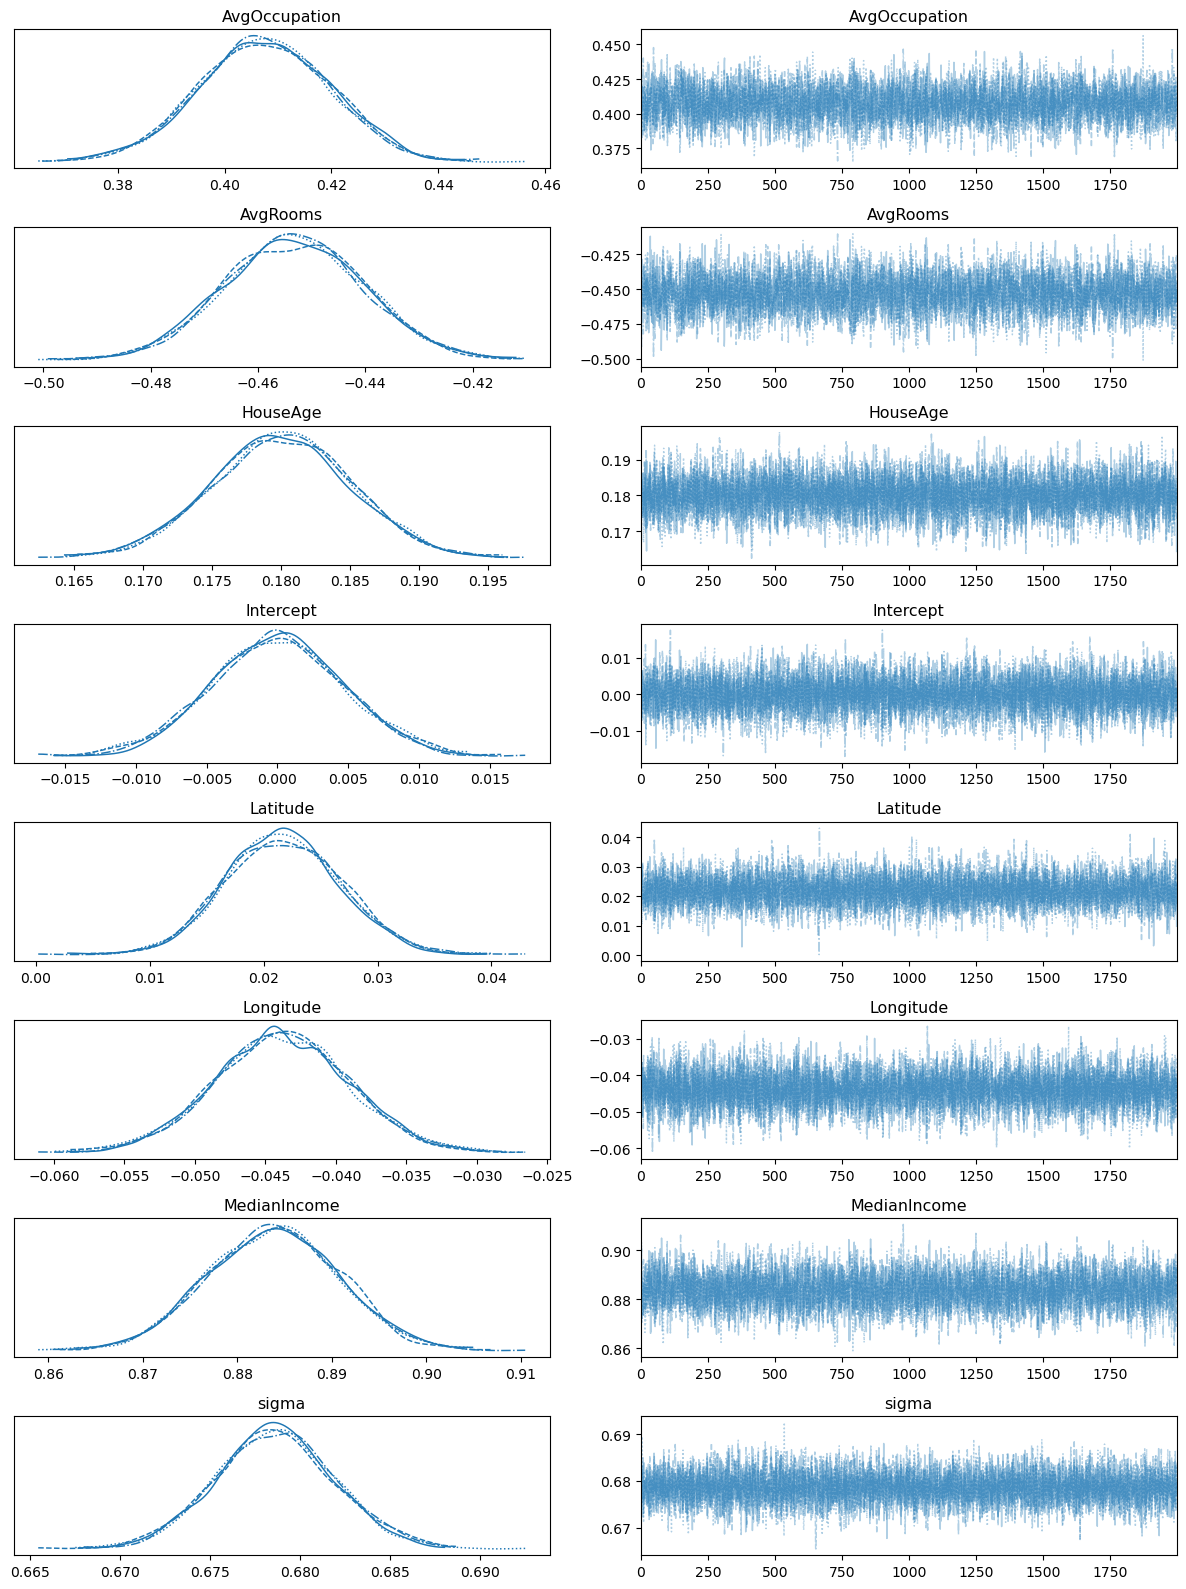

In [ ]:
# Visualize Trace which gives us posterior distributions for the intercept and each beta coefficient

# Left #
#------#
# Posterior distribution plots show the range of values for each coefficient which can help us understand the uncertainty around the causal effect of the variable
# You want to see a normal distribution bell curve - shows the model converged properly; Skewed or multimodal is no good
# Wider distributions shows more uncertainty (narrow=more certainty, but they can be too narrow...)

# Right #
#-------#
# Trace plots: value of sampled parameter at each step of the MCMC process - look for a fuzzy catapillar
# After the inital "burn-in" period, it should look noisy but stable horizontal band - meaning it converged & is exploring the posterior distribution effectively
# It should not show any drift, it should be on the line of the mean
# It should also show good mixing of different values
# Sometimes you discard the early samples that are part of that burn-in period (person does this, so ask him)

# Signals #
#---------#
# Trace plots that are sticky or deviating off the mean
# Trace plots with multiple chains that don't overlap
# Trade plots that are multi-modal
# Too wide or too narrow posterior distributions

# Diagnostics #
#-------------#
# Gelman-Rubin Stat (R-hat) -> check if chains have converged, < 1.1 means chains have converged
# Effective Sample Size -> How many ind samples the MCMC algorithm has drawn, if ESS is smaller than totla samples, then poor mixing
# Check for autocorrelation of MCMC samples
# Trace plots for multiple chains -> set chains=4 on the pm.sample function & check if the chains overlap for good convergence

az.plot_trace(trace)
plt.tight_layout();
# while this may not look fantastic...google what a bad one looks like and you'll see this is perfectly a-okay

<br>

***

<br>

## Summarize Model Results

In [32]:
# ==================================================== #
# Summarize Model Results                              #
# ==================================================== #
# Summary of the posterior distributions
# The 95% HDI shows where the bulk of the poterior mass lies
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
AvgOccupation,0.407,0.012,0.384,0.431,0.0,0.0,4696.0,5052.0,1.0
AvgRooms,-0.453,0.013,-0.479,-0.428,0.0,0.0,4513.0,5232.0,1.0
HouseAge,0.180,0.005,0.170,0.190,0.0,0.0,8153.0,5912.0,1.0
Intercept,0.000,0.005,-0.008,0.010,0.0,0.0,9068.0,5452.0,1.0
Latitude,0.022,0.005,0.012,0.032,0.0,0.0,8362.0,5688.0,1.0
Longitude,-0.044,0.005,-0.053,-0.035,0.0,0.0,9249.0,5694.0,1.0
MedianIncome,0.884,0.007,0.870,0.897,0.0,0.0,5421.0,5546.0,1.0
sigma,0.679,0.003,0.672,0.685,0.0,0.0,9004.0,5681.0,1.0


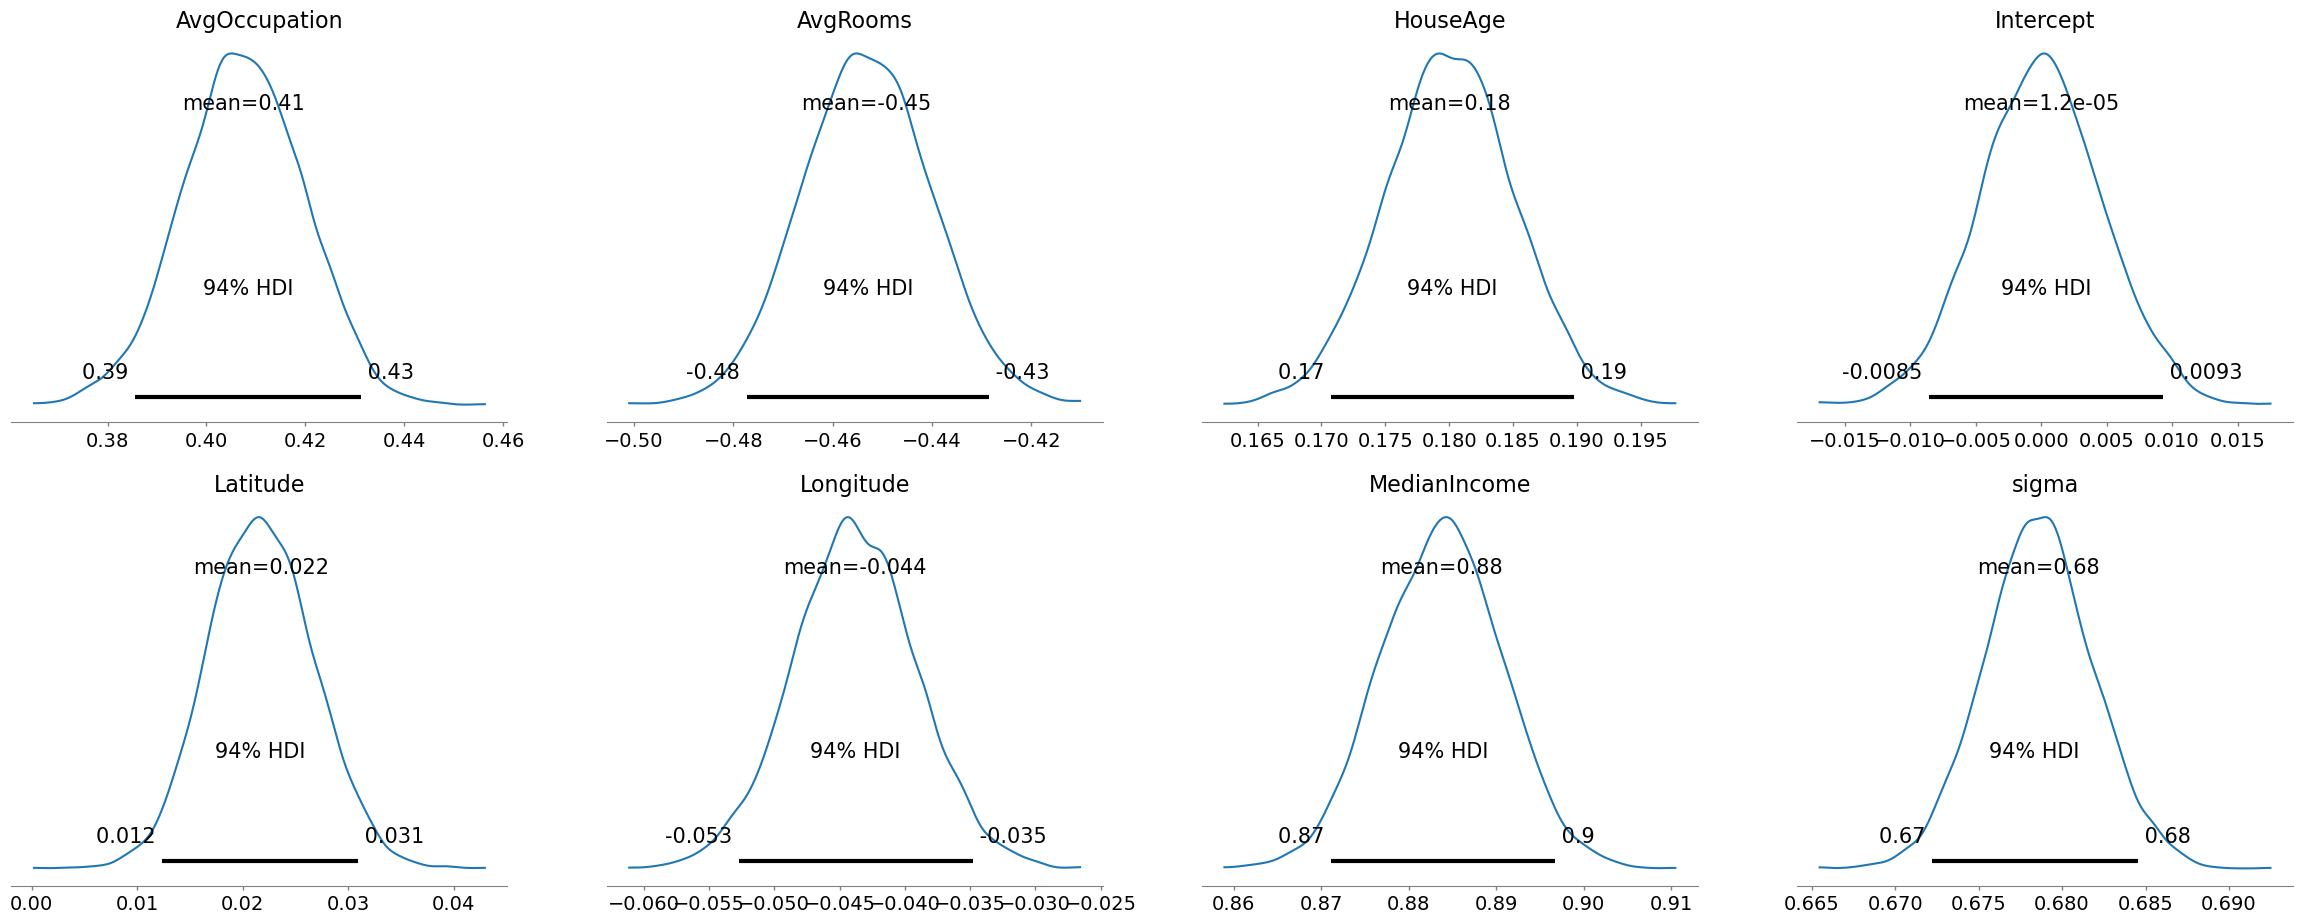

In [14]:
az.plot_posterior(trace);

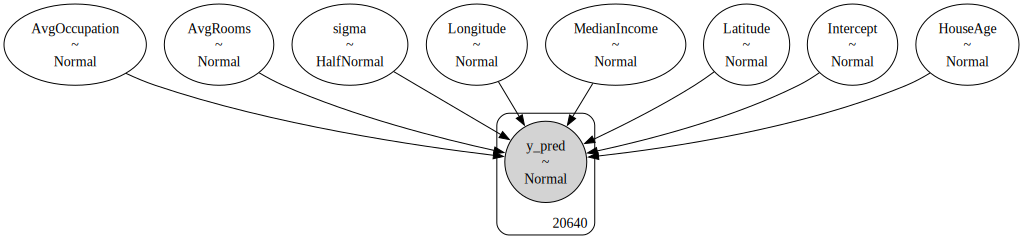

In [15]:
# Graph out model structure
pm.model_to_graphviz(bayesian_model)

In [16]:
# Posterior Predictive Check
ppc = pm.sample_posterior_predictive(trace, model=bayesian_model)

Sampling: [y_pred]


Output()

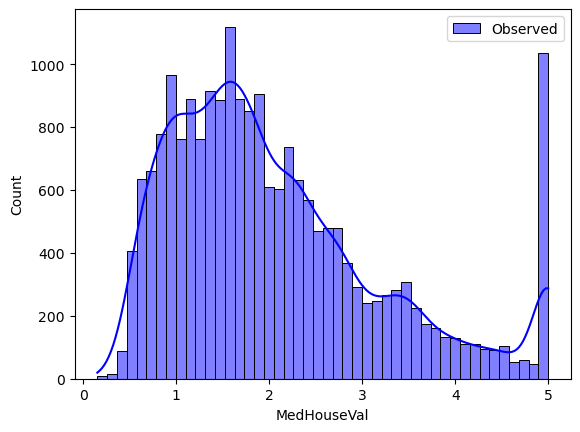

In [17]:
# Compare observed data to simulated posterior data
sns.histplot(y, color='blue', label='Observed', kde=True)
# sns.histplot(ppc.posterior_predictive.y_pred.mean(axis=0), color='orange', label='Posterior Predictive', kde=True)
plt.legend()
plt.show()

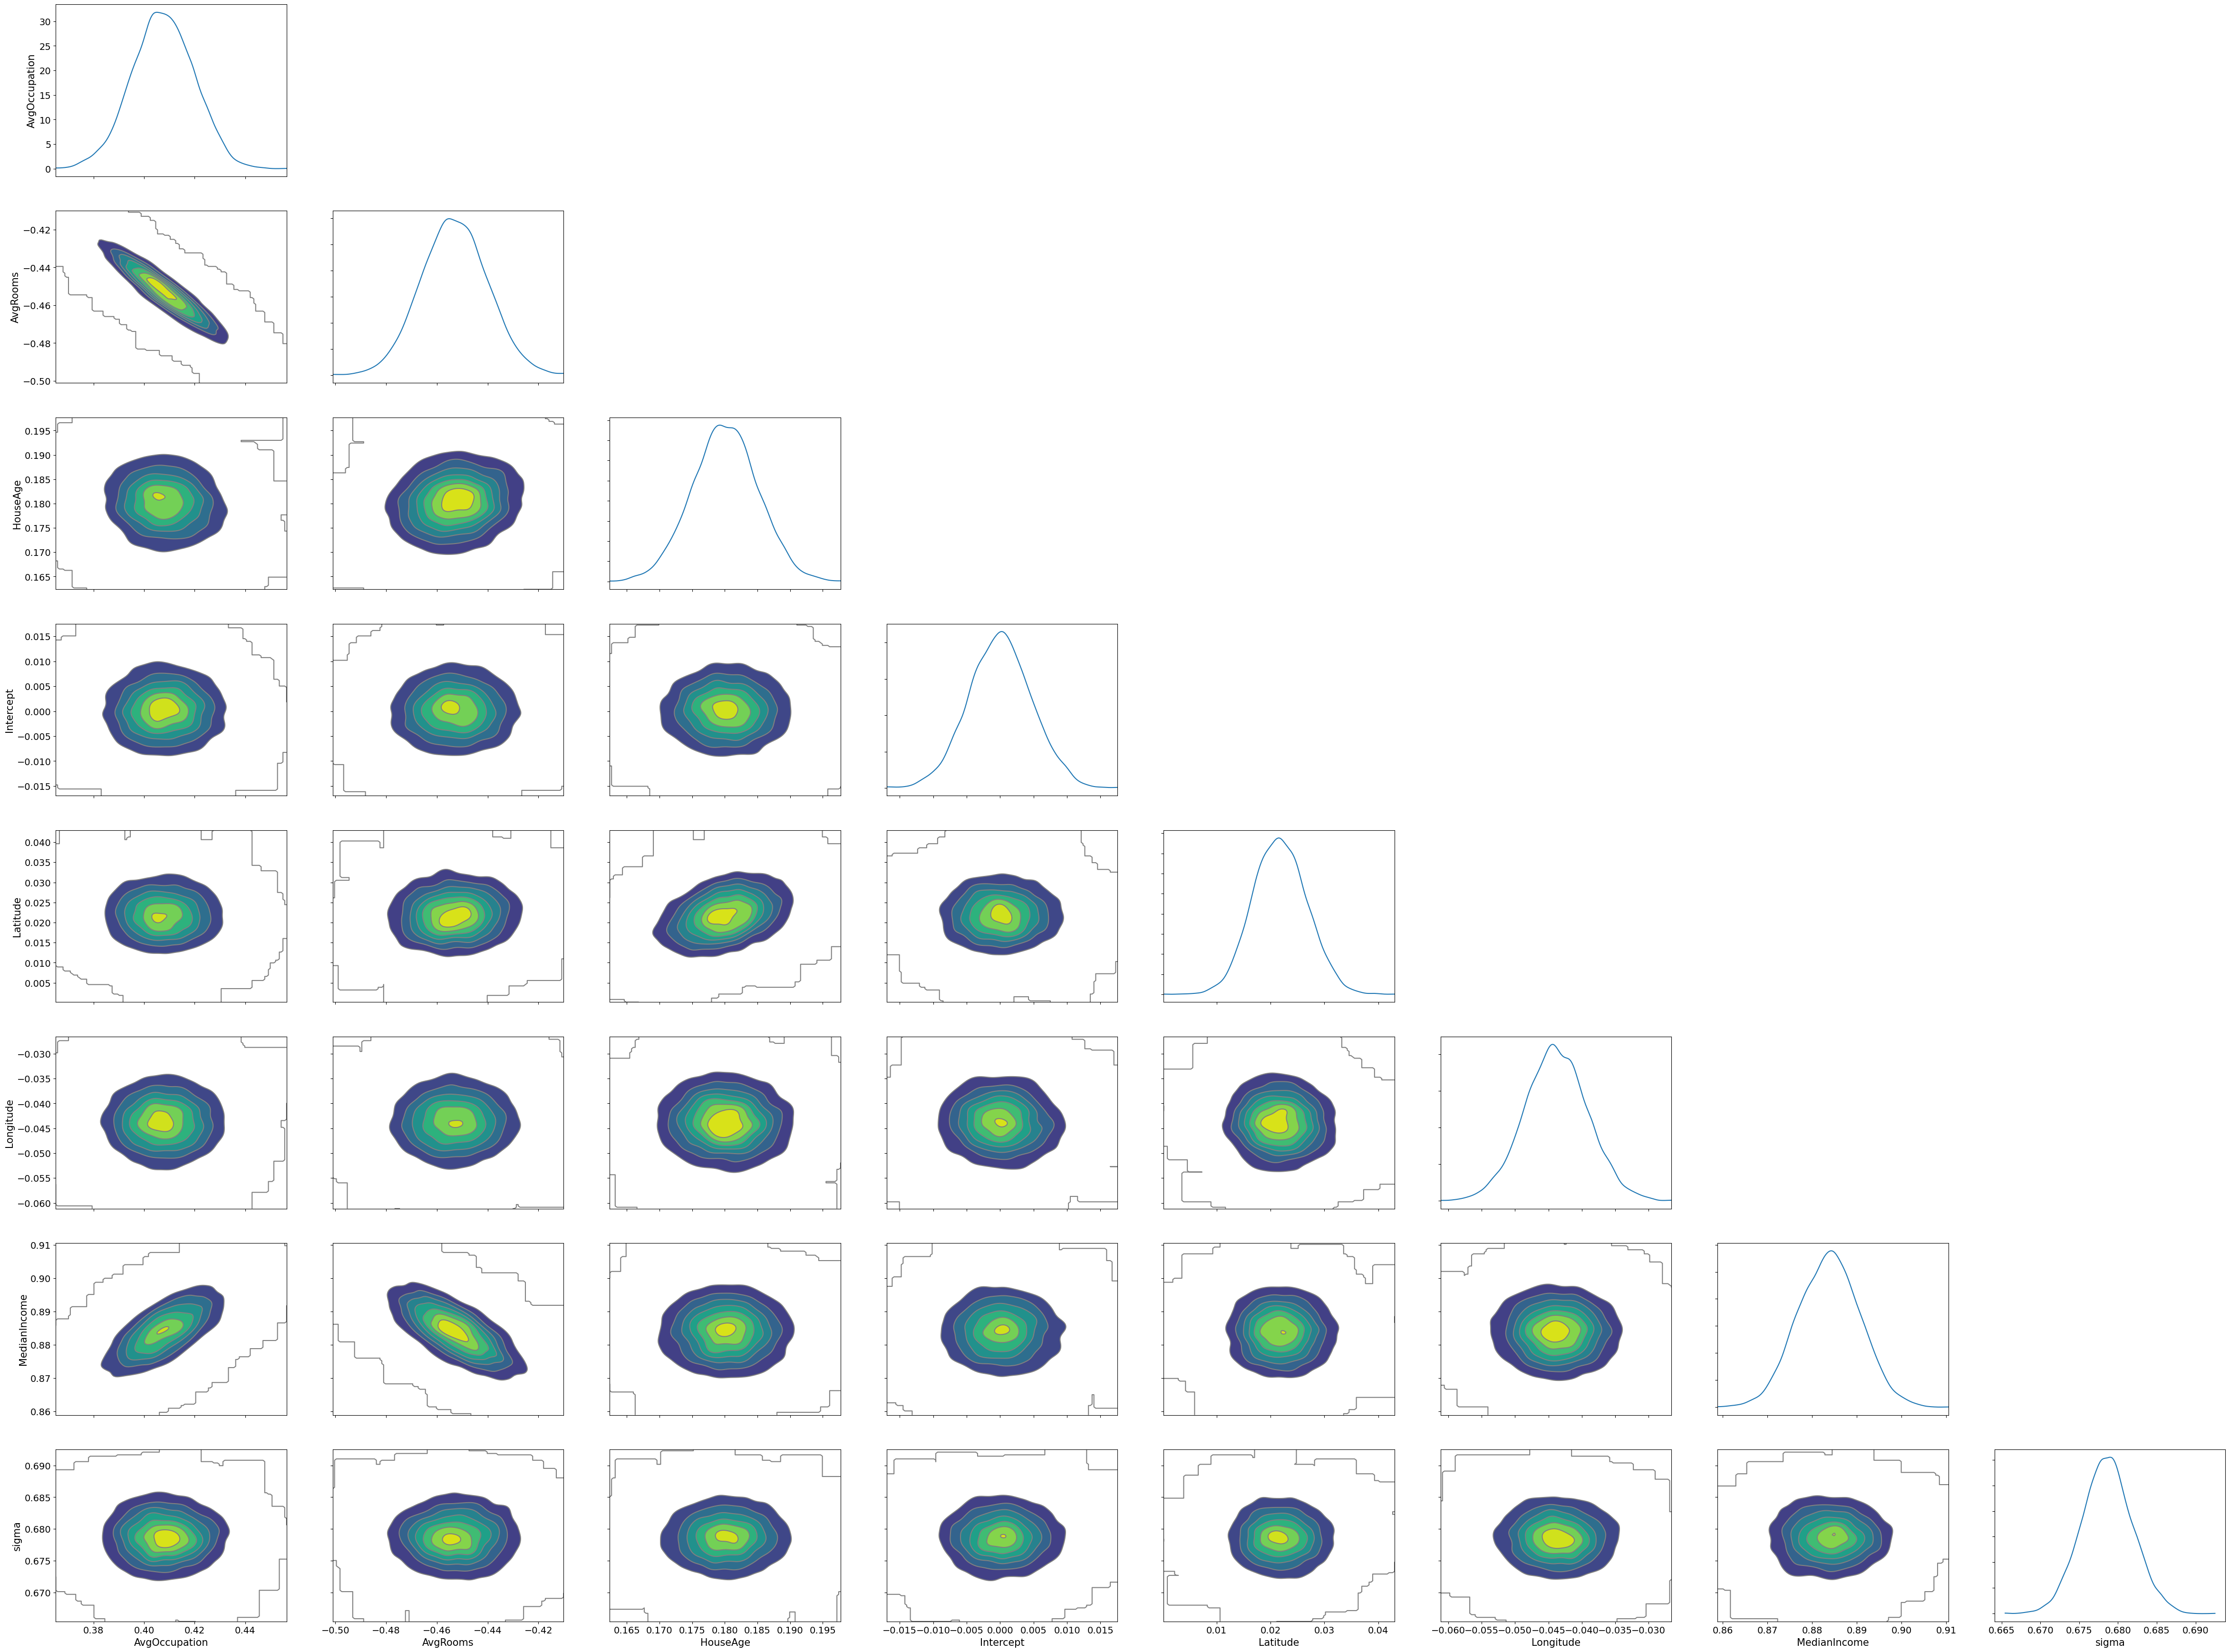

In [18]:
# Pair Plot (Joint Posterior Distributions)
az.plot_pair(trace, kind="kde", marginals=True);

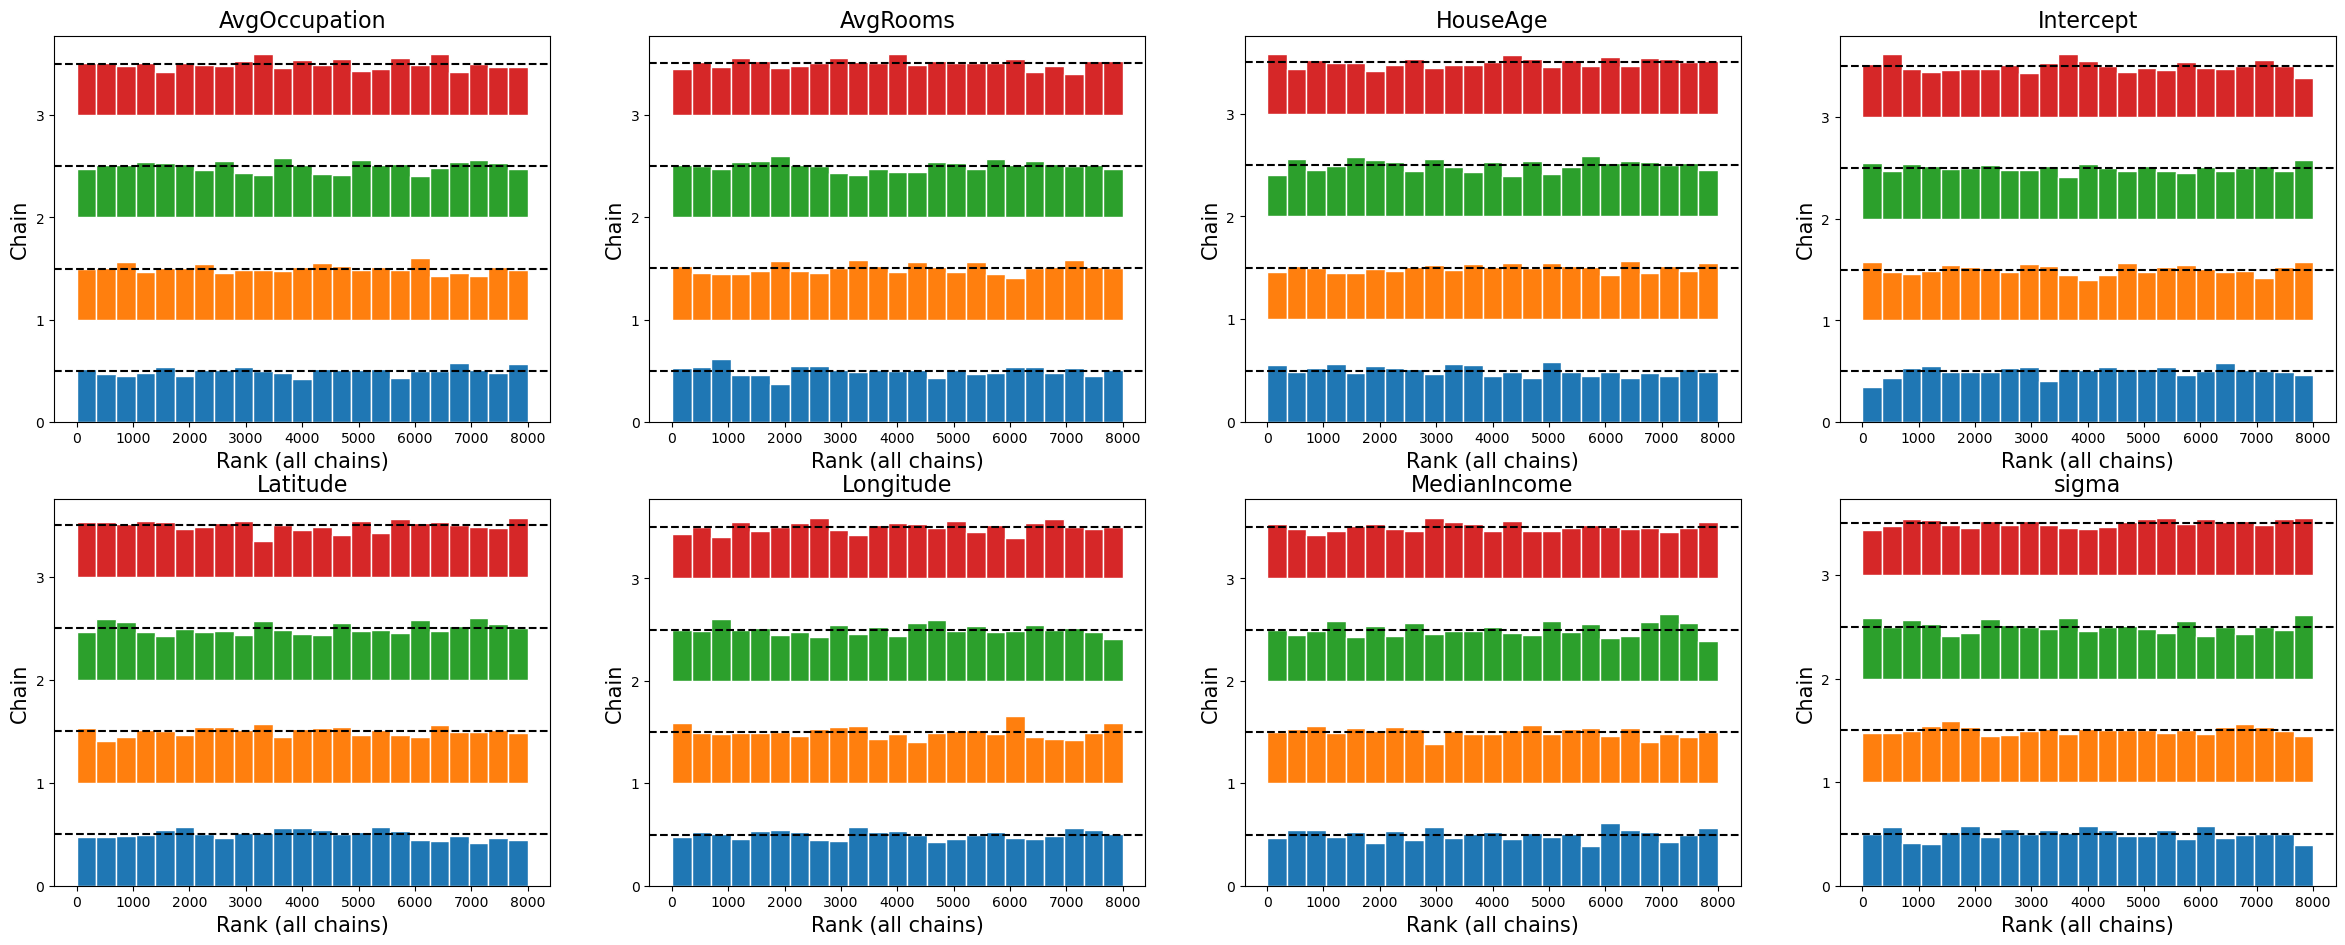

In [19]:
# Rank Plot
az.plot_rank(trace);
plt.show();

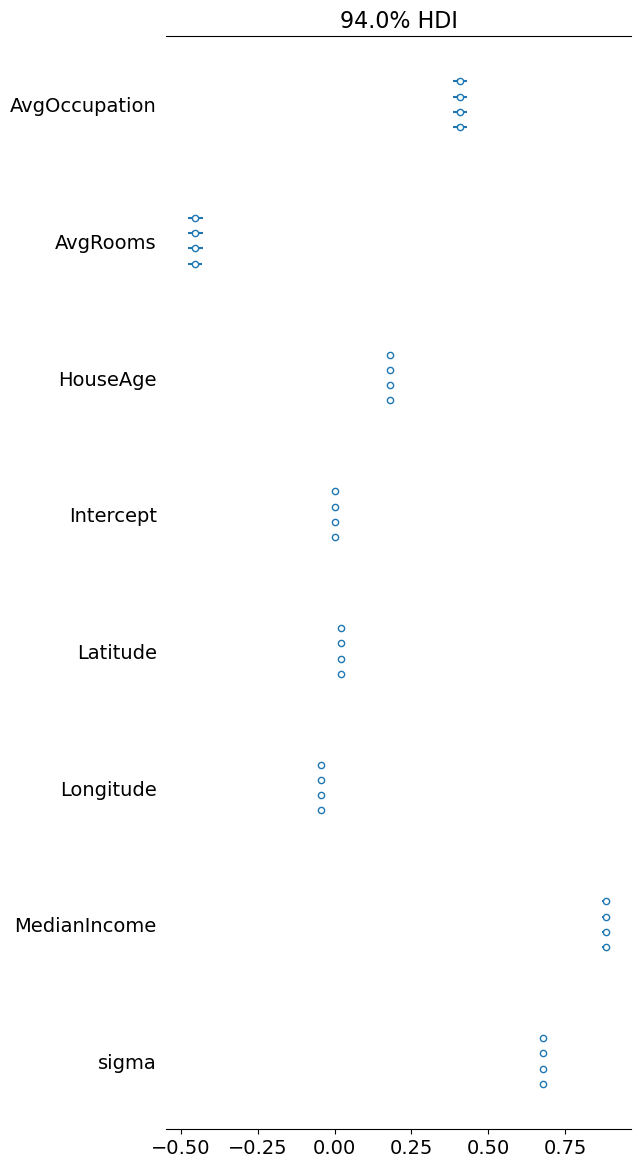

In [20]:
# Posterior Interval Plot (HDI Plot)
az.plot_forest(trace);

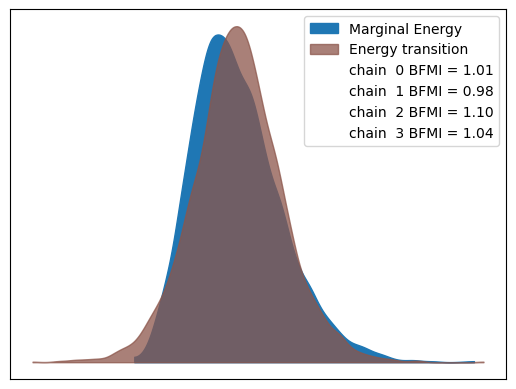

In [21]:
az.plot_energy(trace)
plt.show()

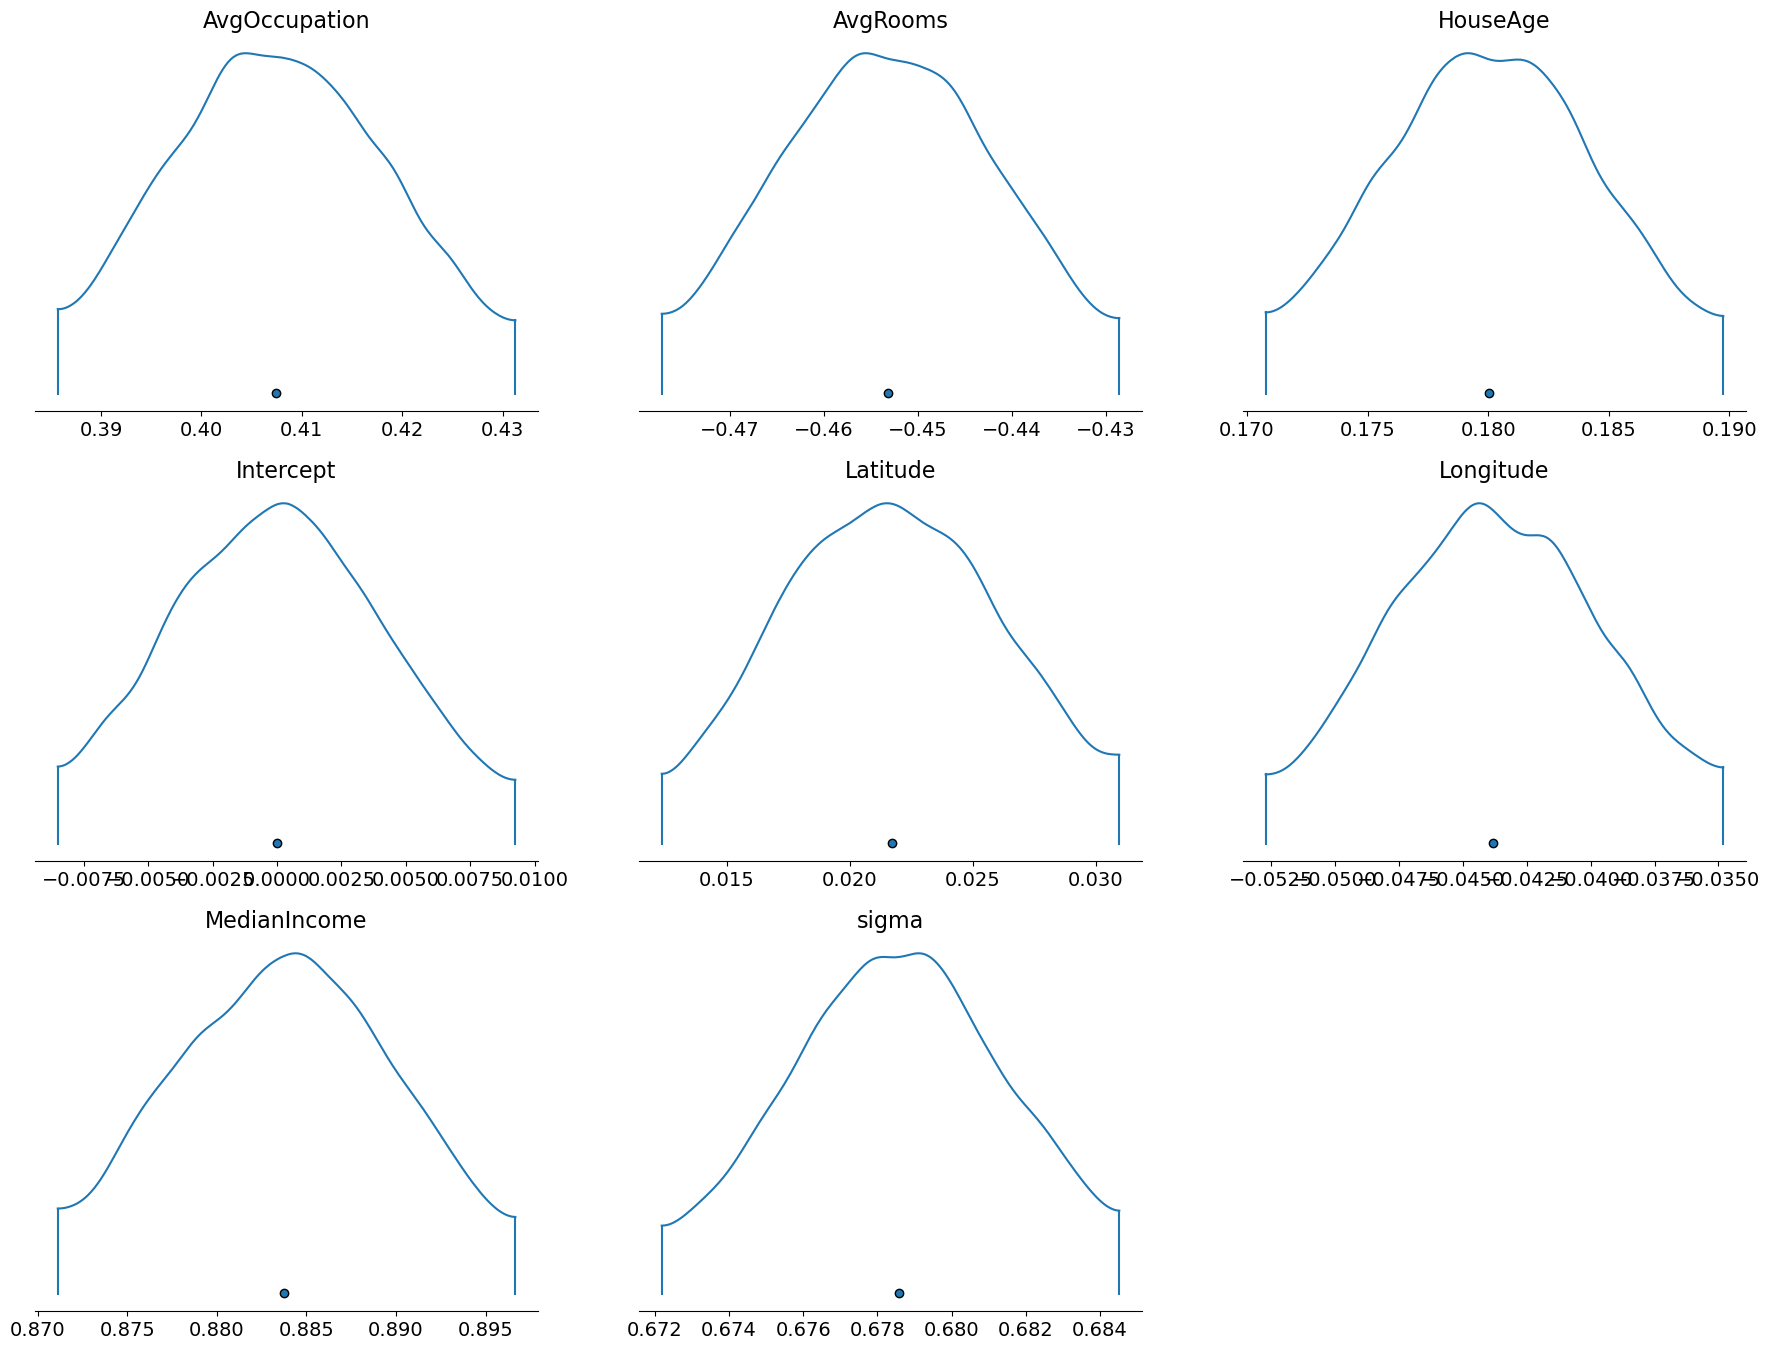

In [22]:
# az.plot_cdf(trace)
az.plot_density(trace)
plt.show()

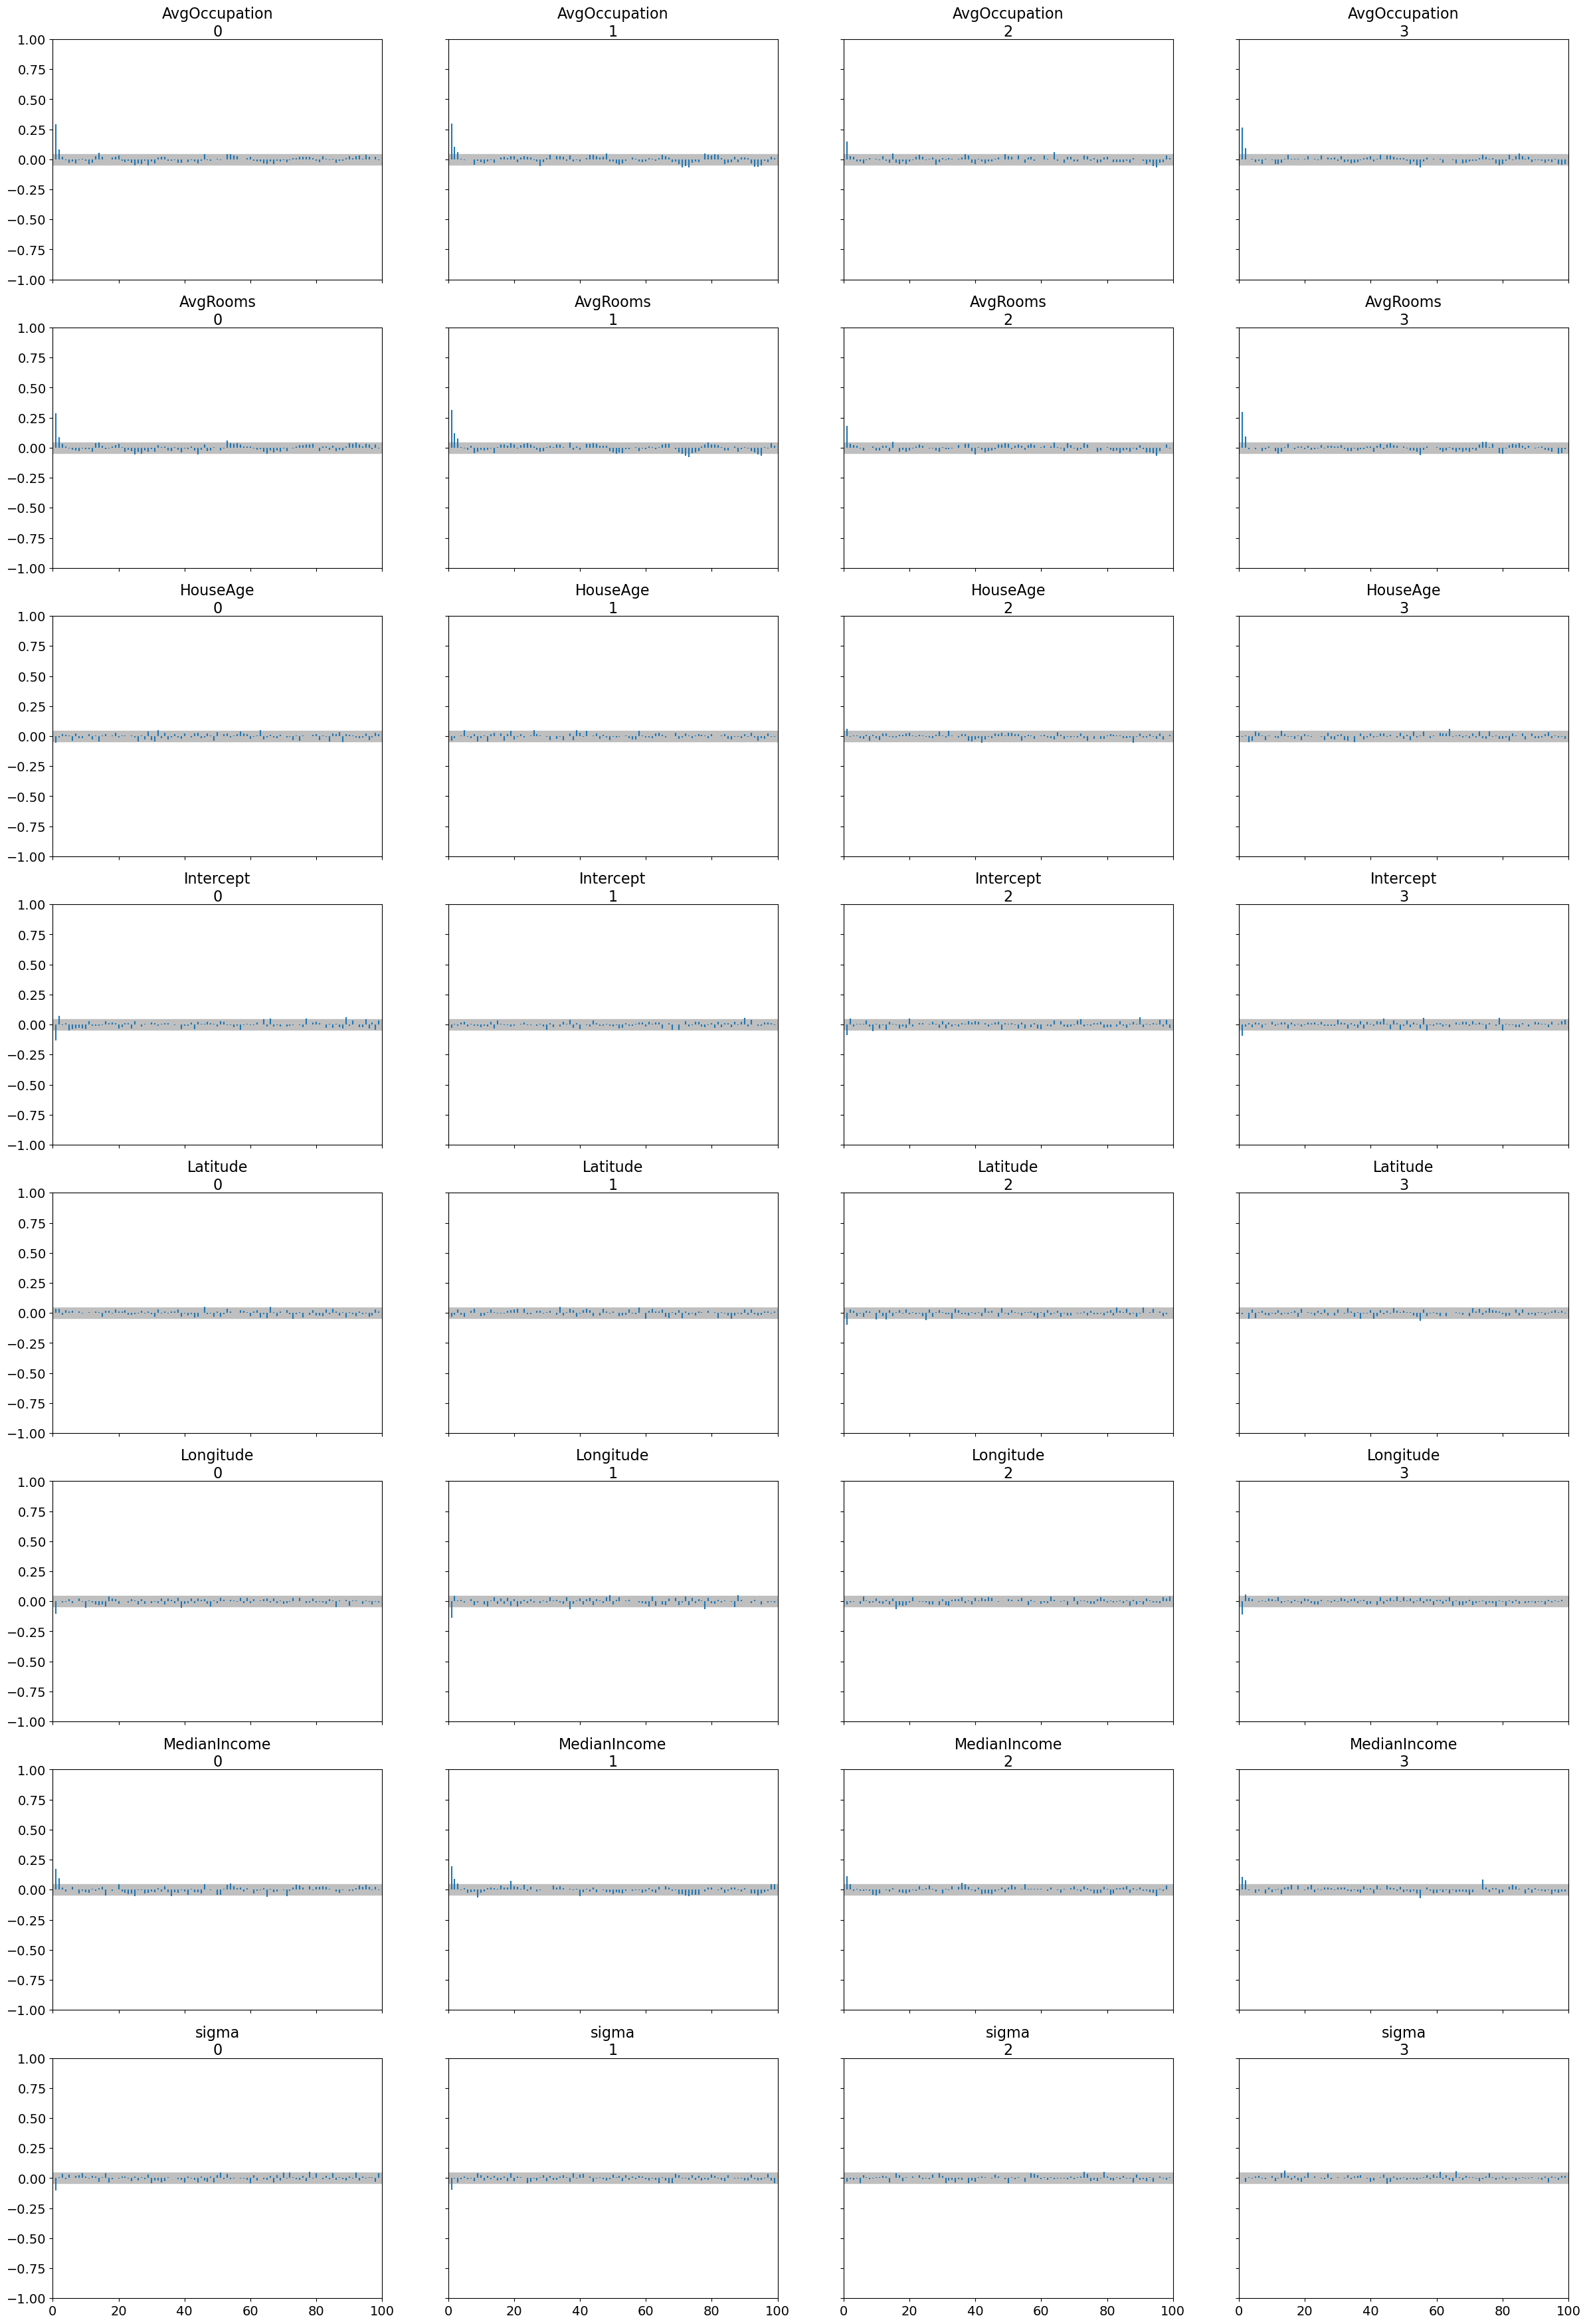

In [23]:
# az.plot_corr(trace)
az.plot_autocorr(trace)
plt.show()

***